In [48]:
import numpy as np
import random as random
import matplotlib.pyplot as plt

In [49]:
states = np.array([0,1])
actions = np.array([0,1]) #0 = stay , #1 = move
N = 5000000 #number of steps
phi = 500 #soft-min parameter
p = 0.01
c = 5
gamma = 0.5
tol_q = 0.1
tol_mu = 0.01
om_q = 0.85
om_mu = 0.55
jump = round(N / 100) # take a measurement of mu every "jump" step

num_X = len(states)
num_A = len(actions)

Q = np.zeros([num_X, num_A], dtype = float) # unified Q function
mu = np.ones([num_X, num_A, num_X], dtype = float) # separate mean field for each trajectory
mu = mu / num_X

def rhosCalc (count_xaxa, count_xa):
    rhoQ = 1 / np.pow(1 + count_xa, om_q)
    rhoMu = 1 / np.pow(1 + count_xaxa, om_mu)
    return { 'q': rhoQ, 'mu': rhoMu }

def env(state, action, mu):
    newS = state
    if random.random() > p:
        newS = (state + action) % 2
    else: 
        newS = (state + action - 1) % 2
    return { "newState": newS,  "cost": state + c * mu[0]}

def pi_xa_policy (Q_xa_state, x, a, state):
    if state == x:
        return a
    else:
        return stable_softmin_action(Q_xa_state, actions)[0]

def stable_softmin_action(q_values, actions, phi=phi):
    scaled_q = -phi * np.array(q_values)
    
    # 2. Key for Stability: Subtract the maximum of the SCALED values 
    # (This aligns the highest value to 0, preventing overflow in exp)
    z = scaled_q - np.max(scaled_q)
    
    # 3. Calculate weights (probabilities) using vectorized operations
    numerator = np.exp(z)
    denominator = np.sum(numerator)
    probabilities = numerator / denominator
    
    # 4. Check for NaNs (safety check after stability fix)
    if np.isnan(probabilities).any():
        print("Warning: NaNs still present in probabilities. Check input Q_values or phi value.")
        # Handle the error gracefully, maybe by choosing a random action uniformly
        return np.random.choice(actions), probabilities
        
    # 5. Return the chosen action based on the probabilities
    return np.random.choice(actions, p=probabilities), probabilities


In [50]:
abridgedmu = []
state = []
for x in range(num_X):
    abridgedmu.append([])
    state.append([])
    for a in range(num_A):
        abridgedmu[x].append([])
        state[x].append(np.random.choice(states, p = mu[x][a])) # initialize state randomly from distribution

# for rho calc, the amount of times in the (x, a) trajectory it has visited a specific state action pair
countMu = np.zeros([num_X, num_A, num_X, num_A], dtype = int)

# for rho calc, the amount of times, regardless of trajectory, it has visited a specific state action pair
countQ = np.zeros([num_X, num_A], dtype = int)

for n in range(N):
    
    for x in range(num_X):

        for a in range(num_A):

            # use softmin to choose next action
            action = pi_xa_policy(Q[state[x][a]], x, a, state[x][a])

            # update counter for rho calculation
            countMu[x][a][state[x][a]][action] += 1
            if state[x][a] == x:
                countQ[state[x][a]][action] += 1
            rhos = rhosCalc(countMu[x][a][state[x][a]][action], countQ[state[x][a]][action])

            # input state, action, mu into environment
            # and receive new state and cost
            envir = env(state[x][a], action, mu[x][a])
            
            # update specific mean field
            delta_X_n = np.zeros(num_X)
            delta_X_n[envir["newState"]] = 1
            mu[x][a] += rhos['mu'] * (delta_X_n - mu[x][a])

            # given state matches the trajectory state, update unified Q matrix, current state, mu distribution
            if state[x][a] == x:
                Q[state[x][a]][action] += rhos['q'] * (envir["cost"] + gamma * np.min(Q[envir["newState"]]) - Q[state[x][a]][action])
    
            state[x][a] = envir["newState"]

            if n % jump == 0:
                abridgedmu[x][a].append(mu[x][a][1])


for x in range(num_X):
    for a in range(num_A):

        abridgedmu[x][a].append(mu[x][a][1])

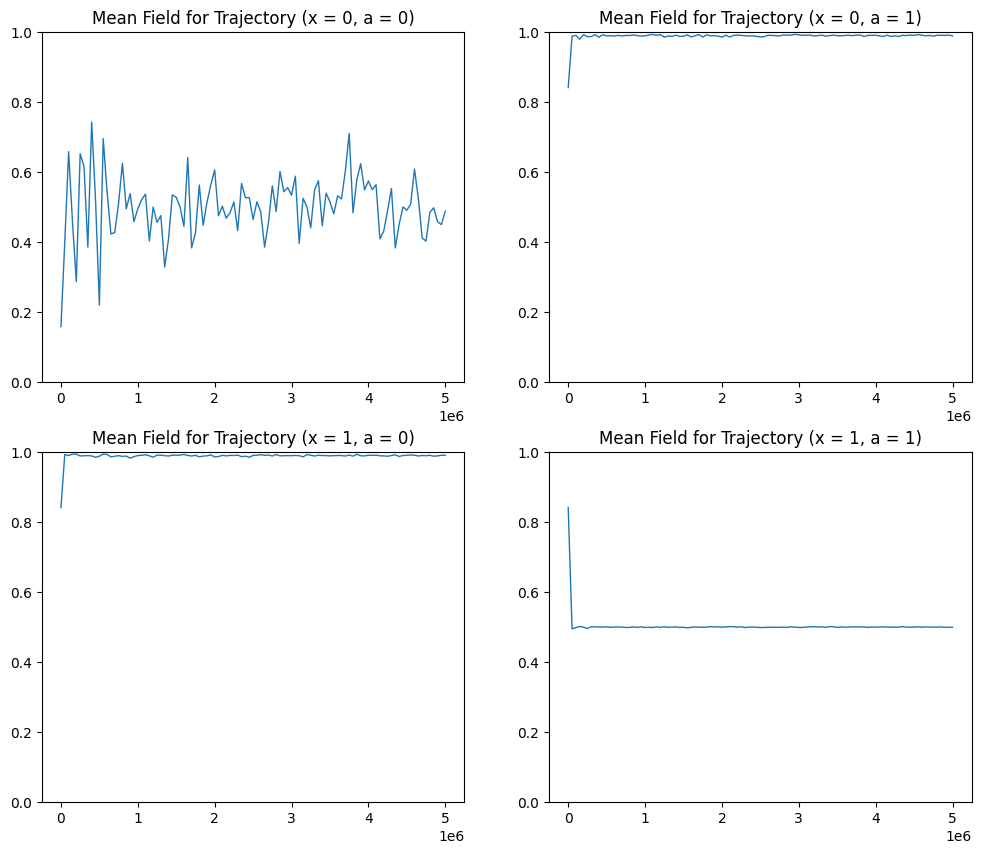

In [51]:
%matplotlib inline

fig, axs = plt.subplots(len(states), len(actions), figsize=(12, 10))

for x in range(num_X):
    for a in range(num_A):
        axs[x, a].plot(range(0, N + jump, jump), abridgedmu[x][a], linewidth = 1)
        axs[x, a].set_ylim([0, 1])
        axs[x, a].set_title("Mean Field for Trajectory (x = %1d, a = %1d)" % (x, a))

In [56]:
print("         a = 0    a = 1")
for x in range(num_X):
    print("x = %1d:  " % (x), end = '')
    for a in range(num_A):
        print("%7.5f  " % (Q[x][a]), end = '')
    print()

         a = 0    a = 1
x = 0:  3.13731  1.09038  
x = 1:  2.08901  4.04993  
